<a href="https://colab.research.google.com/github/FLOWER-2024/TPTITANIC/blob/main/D%C3%A9fi__IM_version_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded successfully.

Data split into training and validation sets.

Starting hyperparameter tuning for the Ensemble model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:02:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble model tuning complete.
Best F1 Score found: 0.7476
Best parameters found:
{'xgb__classifier__reg_lambda': 10.0, 'xgb__classifier__n_estimators': 200, 'xgb__classifier__max_depth': 10, 'xgb__classifier__learning_rate': 0.3, 'rf__classifier__n_estimators': 300, 'rf__classifier__min_samples_split': 5, 'rf__classifier__max_depth': 10, 'lr__classifier__C': 1.0}

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       133
           1       0.78      0.76      0.77       207

    accuracy                           0.72       340
   macro avg       0.71      0.71      0.71       340
weighted avg       0.73      0.72      0.72       340



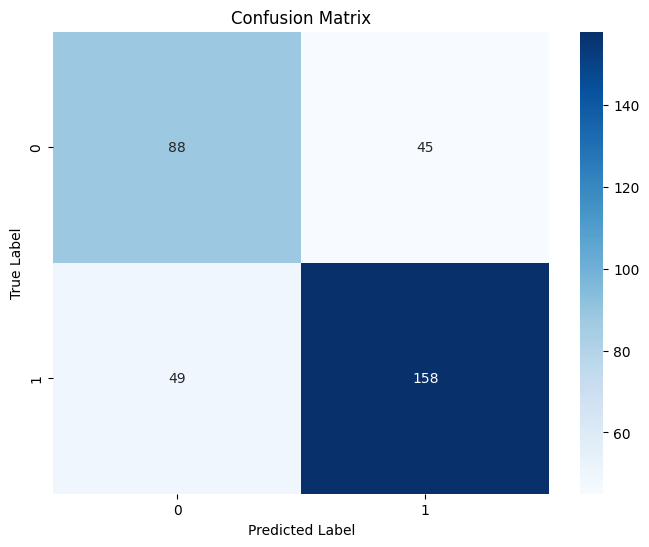


Prediction file 'Groupe_Ensemble_Submission.csv' created successfully.
Head of the submission file:
        ID  pred
1459  1459     1
518    518     0
1693  1693     1
1680  1680     1
611    611     0

Prediction file 'predictions_dfTest.csv' created successfully.
Head of the submission file:
     ID  pred
0   297     1
1  1074     1
2    63     1
3   301     1
4   739     1


In [3]:
# Step 1: Setup and Data Loading
# ---------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Data loading
data_path = '/content/myocardial+infarction+complications.zip'
col_names = [f'col_{i}' for i in range(1, 125)]
df = pd.read_csv(data_path, header=None, names=col_names, na_values='?', compression='zip', dtype=str)

print("Dataset loaded successfully.")

# Step 2: Data Cleaning and Preprocessing
# ---------------------------------------
complication_cols = [f'col_{i}' for i in range(113, 125)]
for col in complication_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['COMPLICATION'] = df[complication_cols].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

feature_cols = [f'col_{i}' for i in range(2, 93)]
for col in feature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

X = df[feature_cols]
y = df['COMPLICATION']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nData split into training and validation sets.")

# Step 3: Construction et optimisation de modèles d'ensemble
# ---------------------------------------------------------
pipe_lr = ImbPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')),  # Changed to 'auto'
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

pipe_rf = ImbPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')), # Changed to 'auto'
    ('classifier', RandomForestClassifier(random_state=42))
])

pipe_xgb = ImbPipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')), # Changed to 'auto'
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

ensemble_clf = VotingClassifier(
    estimators=[('lr', pipe_lr), ('rf', pipe_rf), ('xgb', pipe_xgb)],
    voting='soft'
)

param_dist = {
    'rf__classifier__n_estimators': [50, 100, 200, 300],
    'rf__classifier__max_depth': [3, 5, 10, None],
    'rf__classifier__min_samples_split': [2, 5, 10],
    'xgb__classifier__n_estimators': [50, 100, 200],
    'xgb__classifier__max_depth': [3, 5, 7, 10],
    'xgb__classifier__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'xgb__classifier__reg_lambda': [0.1, 1.0, 10.0],
    'lr__classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

random_search = RandomizedSearchCV(
    estimator=ensemble_clf,
    param_distributions=param_dist,
    n_iter=30,  # Augmente le nombre d'itérations
    cv=5,  # Plus de plis pour une meilleure validation
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\nStarting hyperparameter tuning for the Ensemble model...")
random_search.fit(X_train, y_train)

print("\nEnsemble model tuning complete.")
print(f"Best F1 Score found: {random_search.best_score_:.4f}")
print("Best parameters found:")
print(random_search.best_params_)

best_ensemble = random_search.best_estimator_

# Step 4: Évaluation sur les données de validation
# -----------------------------------------------
y_pred = best_ensemble.predict(X_val)
print("\nClassification Report on Validation Set:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 5: Generating the Final Prediction File
# --------------------------------------------
def predict_and_save(model, test_data, output_filename, threshold=0.6):
    if 'ID' not in test_data.columns:
        test_data['ID'] = test_data.iloc[:, 0]  # Suppose que la première colonne est l'ID
    test_features = test_data[feature_cols].copy()
    for col in test_features.columns:
        test_features[col] = pd.to_numeric(test_features[col], errors='coerce')
    probabilities = model.predict_proba(test_features)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    submission_df = pd.DataFrame({'ID': test_data['ID'], 'pred': predictions})
    submission_df.to_csv(output_filename, index=False)
    print(f"\nPrediction file '{output_filename}' created successfully.")
    print("Head of the submission file:")
    print(submission_df.head())

# Prédictions sur les données de validation
X_val_with_id = X_val.copy()
X_val_with_id['ID'] = X_val.index
predict_and_save(
    model=best_ensemble,
    test_data=X_val_with_id,
    output_filename='Groupe_Ensemble_Submission.csv',
    threshold=0.6
)

# Prédictions sur dfTest.csv
test_data_path = '/content/dfTest.csv'
test_df = pd.read_csv(test_data_path)
test_df.columns = ['ID'] + [f'col_{i}' for i in range(1, 112)]  # Renommage des colonnes pour correspondre

predict_and_save(
    model=best_ensemble,
    test_data=test_df,
    output_filename='predictions_dfTest.csv',
    threshold=0.6
)